In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
import os

In [26]:
path = "/gdrive/MyDrive/Intern/Codes/Colab Notebooks"
add = "Attack_for_2_checkpoints_updated"
path = os.path.join(path,add)
os.mkdir(path = path)

In [27]:
!ls /gdrive/MyDrive/Intern/Codes/Colab\ Notebooks

 AdvGAN.ipynb			    dcgan.ipynb
 Attack_for_2_checkpoints_updated  'Fast Gradient SignMethod.ipynb'
 Attack_for_9_checkpoints	   'Image Classification from scratch.ipynb'
 Attack_for_9_checkpoints_updated  'Image Segmentation.ipynb'
'Basic Classification.ipynb'	    pix2pix.ipynb
 CNN.ipynb			   'Simple  MNIST ConvNet.ipynb'


In [5]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [6]:
import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras import layers
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os, sys
import random

#Loading the dataset

In [7]:
mnist = keras.datasets.mnist
(train_x, train_y), (test_x, test_y) = mnist.load_data()
#Normalization
train_x = train_x/255.0
test_x = test_x/ 255.0

11501568/11490434 [==============================] - 0s 0us/step


In [8]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1)
test_x = test_x.reshape(test_x.shape[0], 28, 28, 1)

The Keras API provides a to_categorical() method that can be used to one-hot encode integer data. If the integer data represents all the possible values of the classes, then the to_categorical() method can be used directly; otherwise, the number of classes can be passed to the method as the num_classes parameter.

In [9]:
print(train_y.shape)
train_y = to_categorical(train_y, num_classes=10)
test_y = to_categorical(test_y, num_classes = 10)
print(train_y.shape)

(60000,)
(60000, 10)


In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [11]:
# Batch and shuffle the dataset
def shuffle(x, y):
  rands = random.sample(range(x.shape[0]),x.shape[0])
  return x[rands], y[rands]

def next_batch(x,y,i,b_size):
  idx = i*b_size
  idx_n = i*b_size + b_size
  return x[idx:idx_n], y[idx:idx_n]

# Create The Models

### 1. Target Model

In [12]:
url = "https://tfhub.dev/tensorflow/tfgan/eval/mnist/logits/1"
target_model = tf.keras.Sequential([hub.KerasLayer(url, input_shape = (28,28,1))])
prediction_model = tf.keras.Sequential([target_model, layers.Softmax()])

In [13]:
optimizer = tf.keras.optimizers.Adam(1e-4)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True)
metrics = ['accuracy']

target_model.compile(optimizer, loss, metrics)

In [14]:
prediction = prediction_model.predict(test_x)

In [15]:
loss, acc = target_model.evaluate(test_x,test_y)
print("Loss : {:0.2f}, Accuracy : {:0.2f} %".format(loss, acc*100))

313/313 [==============================] - 2s 5ms/step - loss: 0.0990 - accuracy: 0.9822
Loss : 0.10, Accuracy : 98.22 %


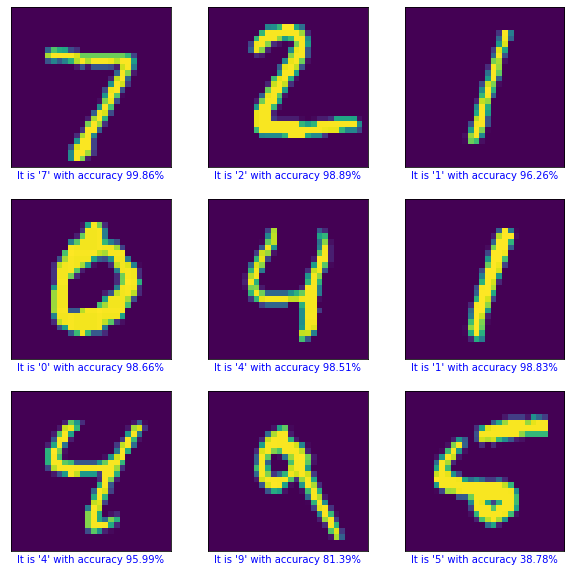

In [17]:
plt.figure(figsize = (10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(test_x[i+0,:,:,0])
  if np.argmax(prediction[i+0]) == np.argmax(test_y[i+0]):
    color = "blue"
  else:
    color = "red"
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel("It is '{}' with accuracy {:0.2f}%".format(np.argmax(prediction[i+0]),
                                                         np.max(prediction[i+0])*100), color = color)
plt.show()

### 2. Discriminator model

In [18]:
from tensorflow.keras import layers
def discriminator():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(filters = 8,kernel_size = (4,4),
                          strides = 2, padding = "valid",
                          input_shape = (28,28,1)))
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2D(16,4,2,padding = "valid"))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2D(32,4,2,padding = "valid"))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation = 'relu'))
  model.add(layers.Dense(1))

  return model

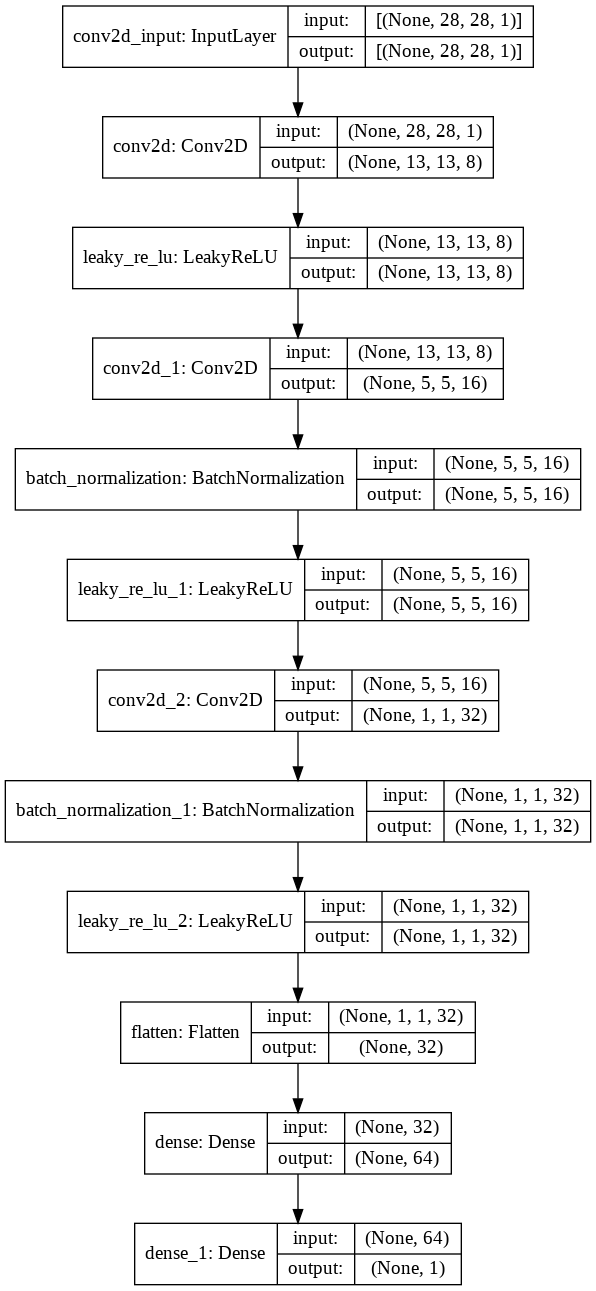

In [19]:
disc = discriminator()
tf.keras.utils.plot_model(disc, show_shapes=True)

In [20]:
disc.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 8)         136       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 16)          2064      
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 5, 16)          64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 32)          8224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 1, 32)         

### 3. Generator

In [28]:
def upsample(filters, size = 3, stride = 2):
  upsample = tf.keras.Sequential()
  upsample.add(layers.Conv2DTranspose(filters, size, strides = stride,
                                      padding = "same"))
  upsample.add(InstanceNormalization())
  upsample.add(layers.ReLU())
  return upsample

def downsample(filters, size = 3, stride = 1):
  downsample = tf.keras.Sequential()
  downsample.add(layers.Conv2D(filters, size, strides = stride,
                               padding = "same"))
  downsample.add(InstanceNormalization())
  downsample.add(layers.ReLU())
  return downsample

def Resblock(filters ,size, s = 1):
  model1 = tf.keras.Sequential()
  model1.add(layers.Conv2D(filters,size,strides = s,padding = "same"))
  model1.add(layers.BatchNormalization())
  model1.add(layers.ReLU())
  
  model1.add(layers.Conv2D(filters,size,strides = s,padding = "same"))
  model1.add(layers.BatchNormalization())
  model1.add(layers.ReLU())

  return model1

In [29]:
def generator():
  inputs = tf.keras.layers.Input(shape=(28,28,1))

  down_stack = [downsample(8,3,1),
                downsample(16,3,2),
                downsample(32,3,2),
                ]

  up_stacks = [upsample(16 ,3,2),
               upsample(8,3,2)]

  res_block = [Resblock(filters=32, size=3, s=1),
               Resblock(filters=32, size=3, s=1),
               Resblock(filters=32, size=3, s=1),
               Resblock(filters=32, size=3, s=1)]
  
  x = inputs
  
  for down in down_stack:
    x = down(x)
  
  for i in res_block:
    y = i(x)
    y = tf.keras.layers.Concatenate()([x, y])
    x = y
  
  for up in up_stacks:
    x = up(x)
  
  x = layers.Conv2DTranspose(1,3,1,"same")(x)
  x = layers.Activation('tanh')(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

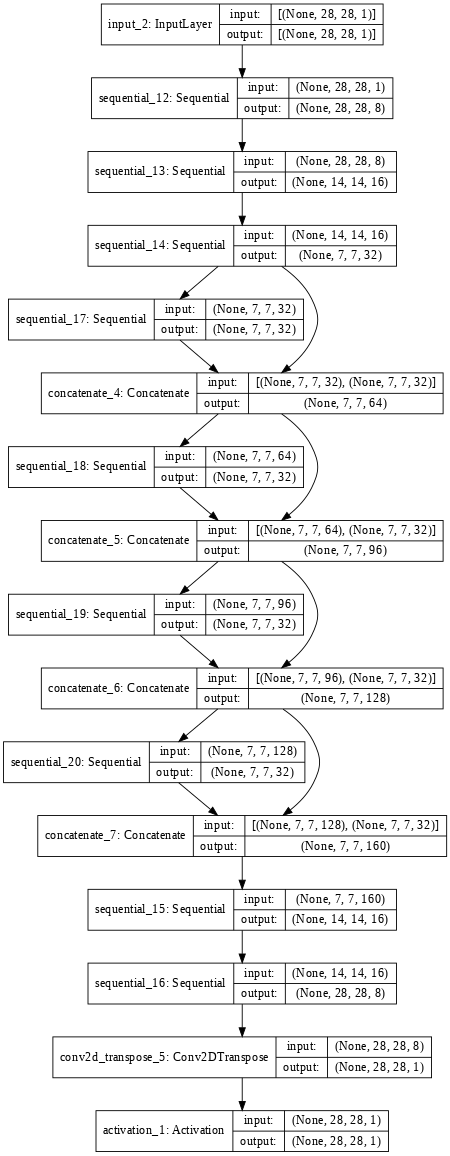

In [30]:
gen = generator()
tf.keras.utils.plot_model(gen, show_shapes=True, dpi = 64)

In [31]:
gen.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 28, 28, 8)    96          input_2[0][0]                    
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 14, 14, 16)   1200        sequential_12[0][0]              
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 7, 7, 32)     4704        sequential_13[0][0]              
____________________________________________________________________________________________

In [33]:
# Target Model
def ModelC():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(32,kernel_size = 3,
                          padding = "same",
                          activation = 'relu', input_shape = [28,28,1]))
  
  model.add(layers.Conv2D(32,kernel_size = 3,
                          padding = "same",
                          activation = 'relu'))
  model.add(layers.MaxPooling2D((2,2)))
  

  model.add(layers.Conv2D(64,kernel_size = 3,
                          padding ="same",
                          activation = 'relu'))
  model.add(layers.Conv2D(64,kernel_size = 3,
                          padding ="same",
                          activation = 'relu'))
  model.add(layers.MaxPooling2D((2,2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(200, activation = 'relu'))
  model.add(layers.Dense(200, activation = 'relu'))
  model.add(layers.Dense(10))

  return model


target_model = ModelC()
tf.keras.utils.plot_model(target_model, show_shapes=True)

# Loss of Target model
loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.Adam(1e-4)

# Training target model
Epochs = 5
Batch_size = 16
target_model.compile(optimizer = optimizer, 
                     loss = loss,
                     metrics = ["accuracy"])

train_X_1, train_y_1 = shuffle(train_x, train_y)
print(train_X_1.shape)
print(train_y_1.shape)

target_model.fit(train_X_1,train_y_1,epochs=Epochs,batch_size=Batch_size)

(60000, 28, 28, 1)
(60000, 10)
Epoch 1/5
3750/3750 [==============================] - 40s 10ms/step - loss: 0.1934 - accuracy: 0.9404
Epoch 2/5
3750/3750 [==============================] - 38s 10ms/step - loss: 0.0575 - accuracy: 0.9820
Epoch 3/5
3750/3750 [==============================] - 38s 10ms/step - loss: 0.0371 - accuracy: 0.9887
Epoch 4/5
3750/3750 [==============================] - 39s 10ms/step - loss: 0.0273 - accuracy: 0.9913
Epoch 5/5
3750/3750 [==============================] - 39s 10ms/step - loss: 0.0194 - accuracy: 0.9938


In [46]:
loss, acc = target_model.evaluate(test_x,test_y)
print("Loss : {:0.2f}, Accuracy : {:0.2f} %".format(loss, acc*100))

313/313 [==============================] - 2s 6ms/step - loss: 0.0304 - accuracy: 0.9911
Loss : 0.03, Accuracy : 99.11 %


In [54]:
prediction_model = tf.keras.Sequential([target_model, layers.Softmax()])
prediction = prediction_model.predict(test_x)

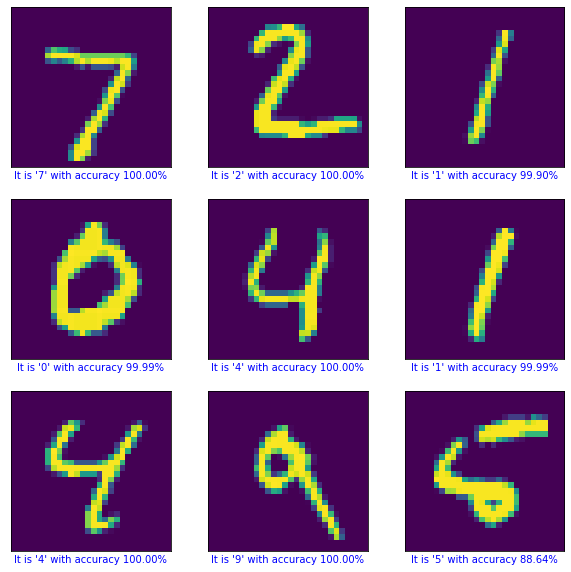

In [55]:
plt.figure(figsize = (10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(test_x[i+0,:,:,0])
  if np.argmax(prediction[i+0]) == np.argmax(test_y[i+0]):
    color = "blue"
  else:
    color = "red"
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel("It is '{}' with accuracy {:0.2f}%".format(np.argmax(prediction[i+0]),
                                                         np.max(prediction[i+0])*100), color = color)
plt.show()

### 4. Adv GAN Model

In [50]:
def discriminator_loss(disc_real_prob, disc_fake_prob):
  
  """  the discriminator seeks to maximize the average of the log probability
   of real images and the log of the inverse probability for fake images."""
   
  """ This method quantifies how well the discriminator is able to distinguish 
   real images from fakes. It compares the discriminator's predictions on real
    images to an array of 1s, and the discriminator's predictions on 
    fake (generated) images to an array of 0s. """


  real_loss = tf.keras.losses.mean_squared_error(tf.ones_like(disc_real_prob),
                                                 disc_real_prob)
  fake_loss = tf.keras.losses.mean_squared_error(tf.zeros_like(disc_fake_prob),
                                                 disc_fake_prob)
  return tf.reduce_mean(real_loss + fake_loss)


def generator_loss(disc_fake_prob):
  # This has the effect of encouraging the generator to generate samples that have a low probability of being fake.
  # Here the generator learns to generate samples that have a low probability of being fake.

  """ The generator's loss quantifies how well it was able to trick the discriminator. 
  Intuitively, if the generator is performing well, the discriminator 
  will classify the fake images as real (or 1). Here, compare the discriminators
   decisions on the generated images to an array of 1s. """

  g_loss_fake = tf.keras.losses.mean_squared_error(tf.ones_like(disc_fake_prob),
                                                   disc_fake_prob)
  return tf.reduce_mean(g_loss_fake)


def perturb_loss(preds, thresh = 0.3):
  # Making preturbation as close to zero as possible
  zeros = tf.zeros(tf.shape(preds)[0],dtype="float32")
  #return tf.reduce_mean(tf.abs(zeros - perturb))
  return tf.reduce_mean(tf.maximum(zeros, tf.norm(tf.reshape(preds, (tf.shape(preds)[0], -1)), axis=1) - thresh))


def adv_loss(f_fake_prob,t, target):
  real = tf.reduce_sum(t*f_fake_prob, 1)
  other = tf.reduce_max((1 - t) * f_fake_prob - (t * 10000), 1)
  if target in range(10):
   return tf.reduce_sum(tf.maximum(0.0, other - real))
  return tf.reduce_sum(tf.maximum(0.0, real - other))


gen_optimizer = tf.keras.optimizers.Adam(2e-4)
disc_optimizer = tf.keras.optimizers.Adam(2e-4)

In [51]:
checkpoint_dir = '/gdrive/MyDrive/Intern/Codes/Colab Notebooks/Attack_for_2_checkpoints_updated/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer,
                                 discriminator_optimizer=disc_optimizer,
                                 generator=gen,
                                 discriminator=disc)

In [82]:
def train_step(input_image, t, target, epoch):
  thresh = 0.3
  f = target_model
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = gen(input_image, training = True)
    
    # generate perturbation, add to original input image(s)
    per = tf.clip_by_value(gen_output, -thresh,thresh)
    x_per = input_image + per
    x_per = tf.clip_by_value(x_per, 0, 1)

    # pass real and perturbed image to discriminator and the target model
    predictions_model = tf.keras.Sequential([disc, layers.Activation('sigmoid')])
    disc_real_prob = predictions_model(input_image, training = True)
    disc_fake_prob = predictions_model(x_per, training = True)

    # pass real and perturbed images to the model we are trying to fool
    predictions_f = tf.keras.Sequential([f, layers.Softmax()])
    f_real_prob = predictions_f(input_image, training = False)
    f_fake_prob = predictions_f(x_per, training = False)

    # LOSS DEFINITIONS
    # discriminator loss
    disc_loss = discriminator_loss(disc_real_prob, disc_fake_prob)
    g_loss_fake = generator_loss(disc_fake_prob)
    per_loss = perturb_loss(per, thresh)
    l_adv = adv_loss(f_fake_prob, t, target)
    if ((epoch+1)%20 == 0):
      print(disc_loss)
      print(g_loss_fake)
      print(per_loss)
      print("\n")
      print(l_adv)
      print("\n")
    
    # weights for generator loss function
    alpha = 5.0
    beta = 8.0
    gross_loss = l_adv + alpha*g_loss_fake + beta*per_loss
  
  gen_gradient = gen_tape.gradient(gross_loss,gen.trainable_variables)
  disc_gradient = disc_tape.gradient(disc_loss, disc.trainable_variables)
  
  gen_optimizer.apply_gradients(zip(gen_gradient, gen.trainable_variables))
  disc_optimizer.apply_gradients(zip(disc_gradient, disc.trainable_variables))

In [83]:
def show(x):
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,1)
  plt.imshow(x[220][:,:,0])
  
  plt.subplot(1,2,2)
  img = tf.expand_dims(x[220],0)
  gen_output = gen(img, training = False)
  gen_output = (1+gen_output)/2
  gen_output = 1-gen_output
  plt.imshow(gen_output[0][:,:,0])
  plt.show()

In [69]:
def fit(x,y,test_x,test_y, epochs=50,batch_size=128,target=-1):
  
  total_batches = x.shape[0]/batch_size
  for epoch in range(epochs):
    #x,y = shuffle(x,y)
    print(epoch+1)
    for i in range(int(total_batches)):
      batch_x, batch_y = next_batch(x,y,i,batch_size)
      if target in range(0,10):
        targets = np.full((batch_y.shape[0],),target)
        batch_y = np.eye(batch_y.shape[-1])[targets]

      train_step(batch_x, batch_y, target,epoch)
    #saving (checkpoint) the model every 20 epochs
    if ((epoch + 1) % 20 == 0):
      checkpoint.save(file_prefix=checkpoint_prefix)
      print("checkpoint saved")

    show(x)

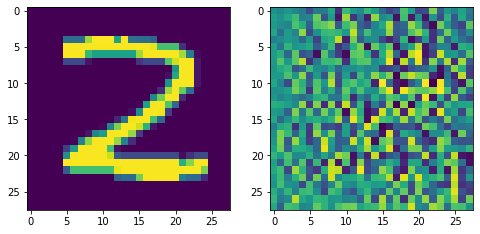

In [70]:
show(train_x)

In [71]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [84]:
fit(train_x, train_y,test_x, test_y, epochs = 150, batch_size=128, target = 2)
# alrady trained for 0 epochs

KeyboardInterrupt: ignored

In [ ]:
acc = []
def predictions(x,y,target=-1):
  batch_size = 128
  tresh = 0.3
  total_batches = int(x.shape[0]/batch_size)

  for i in range(total_batches):
    batch_x, batch_y = next_batch(x,y,i, batch_size)

    if target in range(0,10):
      targates = np.full((batch_y.shape[0],),target)
      batch_y = np.eye(y.shape[-1])[targates]
    test(batch_x,batch_y,target, tresh)
  
  print(" accuracy of test set: {}".format(sum(acc)/(len(acc))))
  
  plt.figure(figsize=(6,6))
  img = tf.expand_dims(test_x[1],0)
  gen_output = 1-gen(img, training = False)
  gen_output /= 2
  plt.subplot(2,2,1)
  plt.imshow(test_x[1][:,:,0])
  plt.subplot(2,2,2)
  plt.imshow(gen_output[0][:,:,0])

  img = tf.expand_dims(test_x[300],0)
  gen_output = 1 - gen(img, training = False)
  gen_output /= 2
  plt.subplot(2,2,3)
  plt.imshow(test_x[300][:,:,0])
  plt.subplot(2,2,4)
  plt.imshow(gen_output[0][:,:,0])

In [ ]:
def test(x,y,target,tresh):

  gen_output = gen(x, training = False)
  per = tf.clip_by_value(gen_output, -tresh, tresh)
  x_per = gen_output + per
  x_per = tf.clip_by_value(x_per, -1, 1)

  f = target_model
  f_real_output = f(x, training = False)
  predictions_f = tf.keras.Sequential([f, layers.Softmax()])
  f_real_prob = predictions_f(x, training = False)
  f_fake_output = f(x_per, training = False)
  f_fake_prob = predictions_f(x_per, training = False)

  correct_prediction = tf.equal(tf.argmax(f_fake_prob, 1), tf.argmax(y, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  acc.append(accuracy)

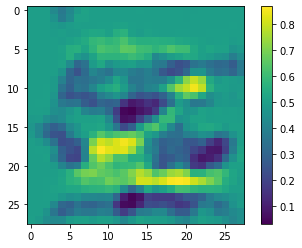

In [ ]:
img = tf.expand_dims(train_x[220],0)
gen_output =1- gen(img, training = False)
gen_output = gen_output/2
plt.figure()
plt.imshow(gen_output[0][:,:,0])
plt.colorbar()

 accuracy of test set: 0.017628205940127373


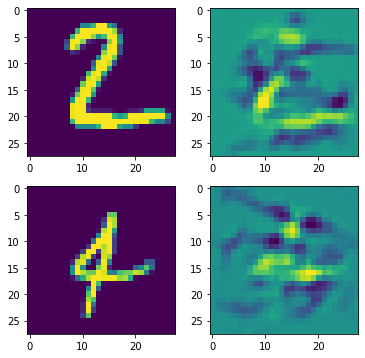

In [ ]:
predictions(test_x, test_y,target = -1)

In [ ]:
prediction_real = prediction_model.predict(test_x)
prediction_fake = prediction_model.predict(gen(test_x))

In [ ]:
generated_test_x = gen(test_x)
generated_test_x = 1-((1 + generated_test_x)/2)

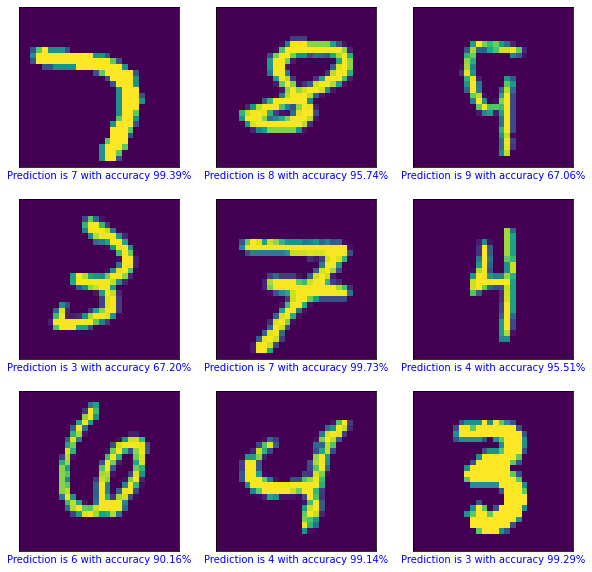

In [ ]:
plt.figure(figsize = (10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(test_x[i+60,:,:,0])
  if np.argmax(prediction_real[i+60]) == np.argmax(test_y[i+60]):
    color = "blue"
  else:
    color = "red"
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel("Prediction is {} with accuracy {:0.2f}%".format(np.argmax(prediction_real[i+60]),
                                                         np.max(prediction_real[i+60])*100), color = color)
plt.show()

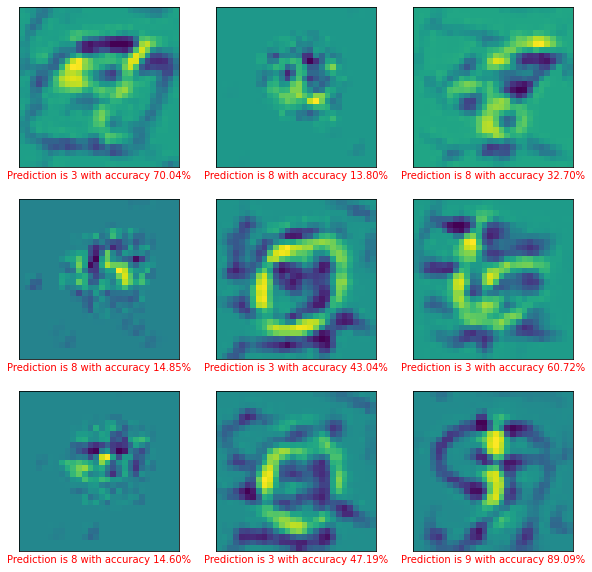

In [ ]:
plt.figure(figsize = (10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(generated_test_x[i+6,:,:,0])
  if np.argmax(prediction_fake[i+6]) == np.argmax(test_y[i+6]):
    color = "blue"
  else:
    color = "red"
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel("Prediction is {} with accuracy {:0.2f}%".format(np.argmax(prediction_fake[i+6]),
                                                         np.max(prediction_fake[i+6])*100), color = color)
plt.show()